In [1]:
import os
import sys
from models import TGEM_Encoder, AE, VAE, TGEM

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from misc import get_dropbox_dir

import json

2024-02-26 13:41:44.363570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dropbox_dir = get_dropbox_dir()
data_dir = os.path.join(dropbox_dir, 'development_CohortCombination/reconstruction_study_feb16')

# Load data
subset_num = 0
X_train = pd.read_csv(os.path.join(data_dir, f'X_train_{subset_num}.csv'), index_col=0)
X_test = pd.read_csv(os.path.join(data_dir, f'X_test_{subset_num}.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(data_dir, f'y_train_{subset_num}.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(data_dir, f'y_test_{subset_num}.csv'), index_col=0)

In [3]:
label_mapping = json.load(open(os.path.join(data_dir, 'label_mapping.json')))


In [4]:
label_mapping
gend_dict = {v: k for k, v in label_mapping['gend'].items()}
gend_inv_dict = {k: v for k, v in label_mapping['gend'].items()}

cohort_dict = {v: k for k, v in label_mapping['cohort'].items()}
cohort_inv_dict = {k: v for k, v in label_mapping['cohort'].items()}


In [5]:
# model_dir = os.path.join(dropbox_dir, 'development_CohortCombination/reconstruction_study_feb16/models_feb16')
model_dir = os.path.join(dropbox_dir, 'development_CohortCombination/reconstruction_study_feb16/adversarial_network_Feb25')

# model_54 = '/Users/jonaheaton/Desktop/mskcc_study_feb13/models_feb20/20240221_012056_0054'
# model_dir = '/Users/jonaheaton/Desktop/mskcc_study_feb13/models_feb20'
# model_54 = os.path.join(dropbox_dir, 'development_CohortCombination/benefit_study_feb20','models_feb20','20240221_012056_0054')


model_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/reconstruction_study_feb16/'
model_subdir = 'models_feb16'

# model_subdir = 'feb26_AE_4_0'
# model_subdir = 'feb26_AE_4_with_head-0.2_and_adversary-5_0'

# model_subdir = '20240219_192130_0053'
# model_subdir = 'test3_0'
# model_subdir = 'feb26_AE_0'
# model_subdir = '20240221_012056_0054'
# model_file = os.path.join(model_dir, model_subdir ,f'unsupervised_{subset_num}_model.pth')
# model_output = os.path.join(model_dir, model_subdir, f'unsupervised_{subset_num}_output.json')

if os.path.exists(os.path.join(model_dir, model_subdir ,f'unsupervised_{subset_num}_model.pth')):
    print('Model file found')
    model_file = os.path.join(model_dir, model_subdir ,f'unsupervised_{subset_num}_model.pth')
    model_output = os.path.join(model_dir, model_subdir, f'unsupervised_{subset_num}_output.json')

elif os.path.exists(os.path.join(model_dir, model_subdir ,f'encoder_model.pth')):
    print('Model file found')
    model_file = os.path.join(model_dir, model_subdir ,f'encoder_model.pth')
    model_output = os.path.join(model_dir, model_subdir, f'encoder_output.json')

elif os.path.exists(os.path.join(model_dir, model_subdir ,f'encoder.pth')):
    print('try alternate')
    model_file = os.path.join(model_dir, model_subdir ,f'encoder.pth')
    model_output = os.path.join(model_dir, model_subdir, f'output.json')

elif os.path.exists(os.path.join(model_dir, model_subdir ,f'tgem_0_model.pth')):
    print('try alternate')
    model_file = os.path.join(model_dir, model_subdir ,f'tgem_0_model.pth')
    model_output = os.path.join(model_dir, model_subdir, f'tgem_0_output.json')

else:
    print('Model file not found')
    model_file = None
    model_output = None


print(model_file)

output_info  = json.load(open(model_output, 'r'))
if 'model_hyperparameters' in output_info:
    model_hyperparams = output_info['model_hyperparameters']
    print(model_hyperparams)
    model_kind = output_info['model_kind']
    print('model kind:', model_kind)
else:
    model_hyperparams = output_info['encoder']['hyperparameters']
    print(model_hyperparams)
    if 'model_kind' in output_info['encoder']['hyperparameters']:
        model_kind = output_info['encoder']['hyperparameters']['model_kind']
        model_hyperparams = {k:v for k,v in output_info['encoder']['hyperparameters'].items() if k != 'model_kind'}
    else:
        model_kind = 'VAE'

# encoder_name = model_hyperparams['model_name']
encoder_name = model_kind

try alternate
/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/reconstruction_study_feb16/models_feb16/tgem_0_model.pth
{'n_head': 5, 'input_size': 937, 'query_gene': 64, 'num_classes': 5, 'd_ff': 1024, 'act_fun': 'linear'}
model kind: TGEM


In [6]:
hue_order = ['adult_cancer','pediatric_other','adult_other','pediatric_CMD','pediatric_cancer']

Text(0.5, 1.0, 'PCA of TGEM on latent space, Test set (N=2475)')

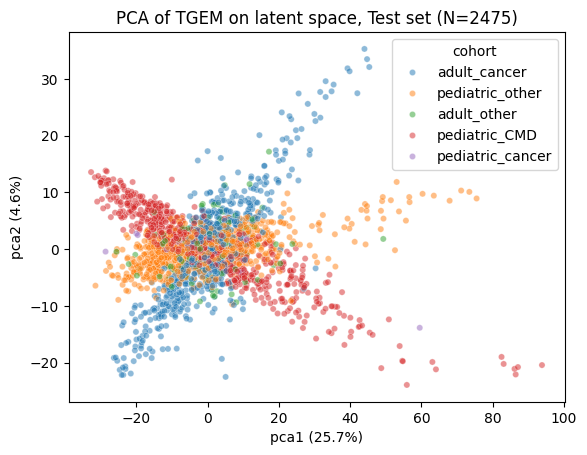

In [7]:

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_test)

# Get explained variance
explained_variance = pca.explained_variance_ratio_

plot_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'], index=X_test.index)
plot_df['cohort'] = y_test['cohort'].map(cohort_dict)
plot_df['study']  = y_test['study str']

# Add explained variance to axis labels
sns.scatterplot(data=plot_df, x='pca1', y='pca2', hue='cohort', s=20, alpha=0.5, hue_order=hue_order, palette='tab10')
plt.xlabel(f'pca1 ({explained_variance[0]*100:.1f}%)')
plt.ylabel(f'pca2 ({explained_variance[1]*100:.1f}%)')
plt.title(f'PCA of {encoder_name} on latent space, Test set (N={len(X_test)})')

# remove the legend
# plt.legend().remove()

In [8]:
# reducer_org = umap.UMAP()
# embedding_org = reducer_org.fit_transform(X_test)

# plot_df = pd.DataFrame(embedding_org, columns=['UMAP1', 'UMAP2'], index=X_test.index)
# plot_df['cohort'] = y_test['cohort'].map(cohort_dict)
# plot_df['study'] = y_test['study str']

# # Create the scatterplot
# sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='cohort', s=20, alpha=0.5, hue_order=hue_order, palette='tab10')
# plt.title(f'UMAP of {encoder_name} on latent space, Test set (N={len(X_test)})')

In [9]:
if model_kind == 'AE':
    encoder = AE(**model_hyperparams)
    encoder.load_state_dict(torch.load(model_file))
elif model_kind == 'VAE':
    encoder = VAE(**model_hyperparams)
    encoder.load_state_dict(torch.load(model_file))
elif model_kind == 'TGEM':
    model_hyperparams = {k:v for k,v in output_info['model_hyperparameters'].items() if k != 'num_classes'}
    encoder = TGEM_Encoder(**model_hyperparams)
    try:
        encoder.load_state_dict(torch.load(model_file))
    except RuntimeError:
        existing_model = TGEM(**output_info['model_hyperparameters'])
        # existing_model = get_model(model_kind, **output_info['model_hyperparameters'])
        existing_model.load_state_dict(torch.load(model_file))
        ignore_keys = ['fc.weight', 'fc.bias']
        state_dict = {k: v for k, v in existing_model.state_dict().items() if k not in ignore_keys}
        encoder.load_state_dict(state_dict, strict=False)
                # print('Loaded (pre-trained on other task) model:', load_model_path)

init
init
init
init
init
init


In [12]:
with torch.inference_mode():

    if model_kind == 'VAE' or model_kind == 'AE':
        # X_test_tor = torch.tensor(torch.tensor(X_test.values, dtype=torch.float32))
        Z_test = encoder.transform(torch.tensor(X_test.values, dtype=torch.float32))
        X_recon = encoder.generate(Z_test)
        Z_test = Z_test.detach().numpy()
        Z_test = pd.DataFrame(Z_test, index=X_test.index)

        # get the reconstruction loss
        recon_loss = F.mse_loss(X_recon, torch.tensor(X_test.values, dtype=torch.float32), reduction='mean')
        print('reconstruction loss:', recon_loss.item())
    else:
        X_test_tor = torch.tensor(torch.tensor(X_test.values, dtype=torch.float32))
        batch_size = 64
        Z_test_tor = torch.tensor([])
        for i in range(0, len(X_test_tor), batch_size):
            print(i, len(X_test_tor))
            Z_test_btz = encoder(X_test_tor[i:i+batch_size])
            Z_test_tor = torch.cat((Z_test_tor, Z_test_btz), dim=0)
        # Z_test = encoder(torch.tensor(X_test.values, dtype=torch.float32))
        Z_test = Z_test_tor.detach().numpy()
        Z_test = pd.DataFrame(Z_test, index=X_test.index)


/var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_10608/1286048264.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tor = torch.tensor(torch.tensor(X_test.values, dtype=torch.float32))


0 2475
64 2475
128 2475
192 2475
256 2475
320 2475
384 2475
448 2475
512 2475
576 2475
640 2475
704 2475
768 2475
832 2475
896 2475
960 2475
1024 2475
1088 2475
1152 2475
1216 2475
1280 2475
1344 2475
1408 2475
1472 2475
1536 2475
1600 2475
1664 2475
1728 2475
1792 2475
1856 2475
1920 2475
1984 2475
2048 2475
2112 2475
2176 2475
2240 2475
2304 2475
2368 2475
2432 2475


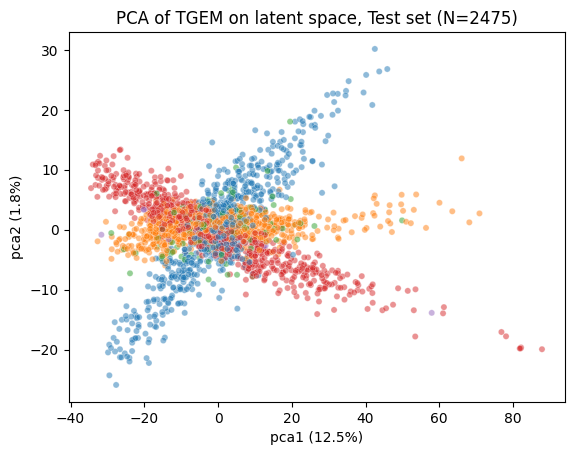

In [13]:


# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Z_test)

# Get explained variance
explained_variance = pca.explained_variance_ratio_

plot_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'], index=X_test.index)
plot_df['cohort'] = y_test['cohort'].map(cohort_dict)
plot_df['study']  = y_test['study str']

# Add explained variance to axis labels
sns.scatterplot(data=plot_df, x='pca1', y='pca2', hue='cohort', s=20, alpha=0.5, hue_order=hue_order, palette='tab10')
plt.xlabel(f'pca1 ({explained_variance[0]*100:.1f}%)')
plt.ylabel(f'pca2 ({explained_variance[1]*100:.1f}%)')
plt.title(f'PCA of {encoder_name} on latent space, Test set (N={len(X_test)})')

# remove the legend
plt.legend().remove()

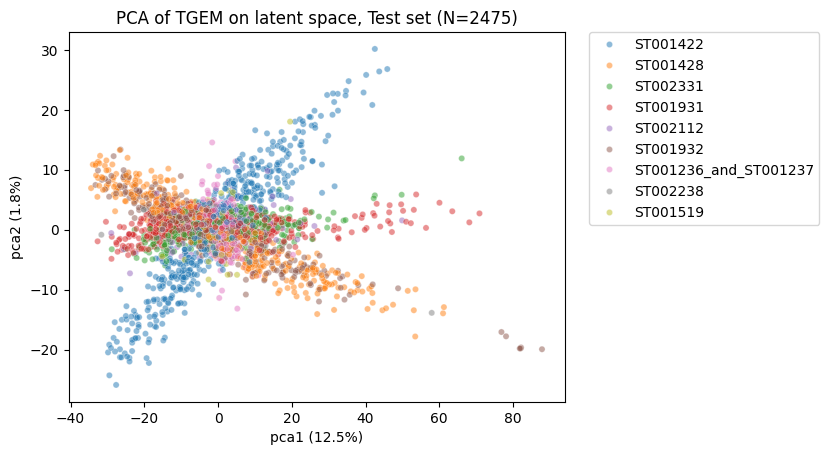

In [14]:
# Add explained variance to axis labels
sns.scatterplot(data=plot_df, x='pca1', y='pca2', hue='study', s=20, alpha=0.5)
plt.xlabel(f'pca1 ({explained_variance[0]*100:.1f}%)')
plt.ylabel(f'pca2 ({explained_variance[1]*100:.1f}%)')
plt.title(f'PCA of {encoder_name} on latent space, Test set (N={len(X_test)})')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [15]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(Z_test)


Text(0.5, 1.0, 'UMAP of TGEM on latent space, Test set (N=2475)')

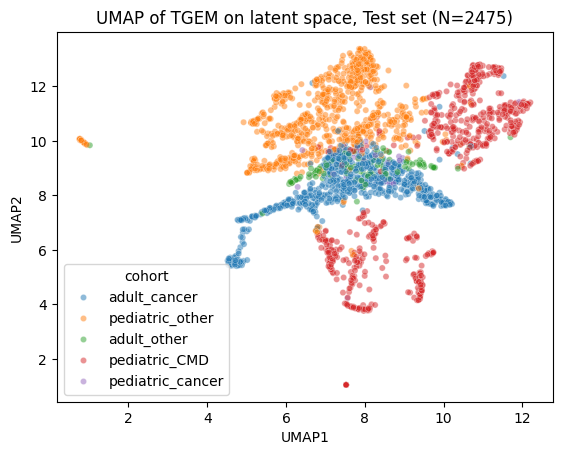

In [16]:
# Create a dataframe for plotting
plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=X_test.index)
plot_df['cohort'] = y_test['cohort'].map(cohort_dict)
plot_df['study'] = y_test['study str']

# Create the scatterplot
sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='cohort', s=20, alpha=0.5, hue_order=hue_order, palette='tab10')
plt.title(f'UMAP of {encoder_name} on latent space, Test set (N={len(X_test)})')
# remove the legend
# plt.legend().remove()

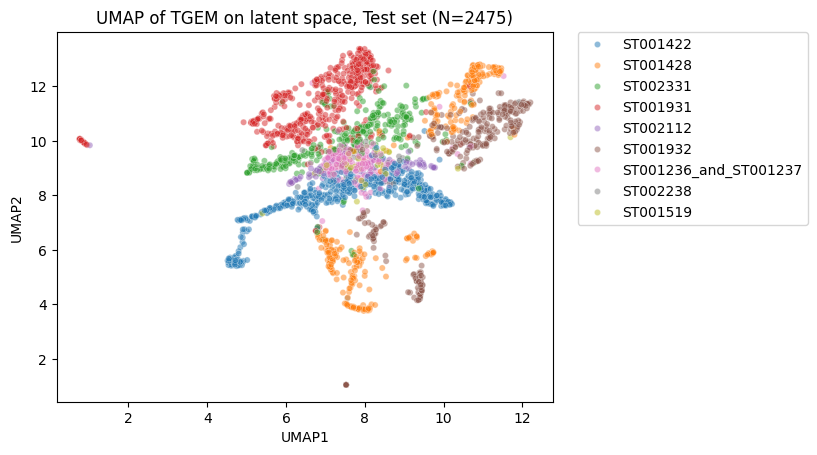

In [17]:
# Create the scatterplot
sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='study', s=20, alpha=0.5)
plt.title(f'UMAP of {encoder_name} on latent space, Test set (N={len(X_test)})')
# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## On the Training Data

Text(0.5, 1.0, 'PCA of VAE on latent space, Train set (N=7423)')

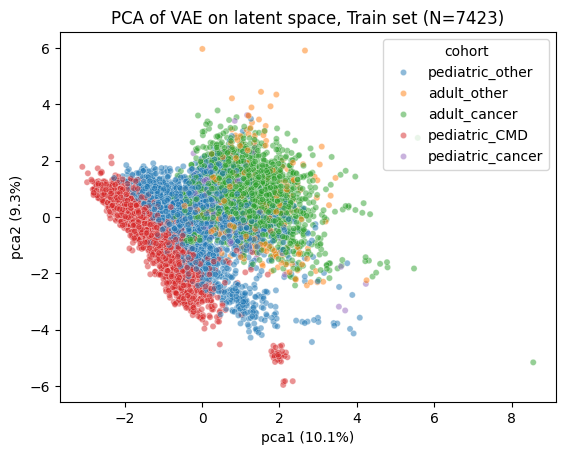

In [68]:
Z = encoder.transform(torch.tensor(X_train.values, dtype=torch.float32))
Z = Z.detach().numpy()
Z = pd.DataFrame(Z, index=X_train.index)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Z)

# Get explained variance
explained_variance = pca.explained_variance_ratio_

plot_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'], index=X_train.index)
plot_df['cohort'] = y_train['cohort'].map(cohort_dict)

# Add explained variance to axis labels
sns.scatterplot(data=plot_df, x='pca1', y='pca2', hue='cohort', s=20, alpha=0.5)
plt.xlabel(f'pca1 ({explained_variance[0]*100:.1f}%)')
plt.ylabel(f'pca2 ({explained_variance[1]*100:.1f}%)')
plt.title(f'PCA of {encoder_name} on latent space, Train set (N={len(X_train)})')

Text(0.5, 1.0, 'UMAP of VAE on latent space, Train set (N=7423)')

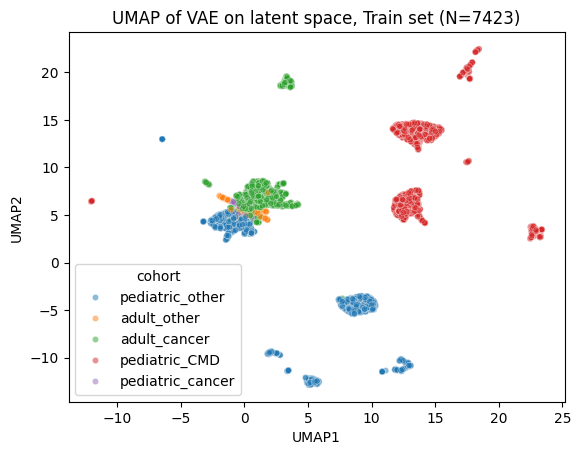

In [69]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(Z)

# Create a dataframe for plotting
plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=X_train.index)
plot_df['cohort'] = y_train['cohort'].map(cohort_dict)

# Create the scatterplot
sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='cohort', s=20, alpha=0.5)
plt.title(f'UMAP of {encoder_name} on latent space, Train set (N={len(X_train)})')